# Testing SHAP DeepExplainer

In [2]:
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada import root_to_df, filter_region, filter_tag, drop_fakes, drop_twodim
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

In [3]:
data_path = "../processed_data/"
signal = "Xtohh2000_Hw"
region = "SR"
tag=2

In [4]:
df_csv = pd.read_csv(data_path+"Xtohh2000.csv")
df_csv =  filter_region(df_csv,region )
df_csv = filter_tag(df_csv, tag)
df_csv["m_region"].value_counts()
df_csv
y = df_csv["sample"] == signal
display(df_csv.head())
df_csv.columns

,sample,EventWeightNoXSec,EventWeight,EventNumber,m_region,m_FJNbtagJets,m_AntiBTag,m_AntiTauTag,m_FJpt,m_FJeta,...,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt,m_hhm_Coll,m_hhm_Eff,m_hhm_ConEff,m_hhm_ConVis
0,Xtohh2000_Hw,0.008301,0.001020,46746,SR,2,3,0,885.55927,0.104927,...,3.105514,3.216185,-0.192894,237.88724,1631.6702,263.697630,-999.0,1896.5974,1193.0669,1973.7532
4,Xtohh2000_Hw,0.009094,0.001117,47033,SR,2,2,0,855.69904,0.313113,...,2.779941,2.848176,-0.019178,485.03333,1293.4028,463.512360,-999.0,1832.4620,1597.4098,1934.0298
15,Xtohh2000_Hw,0.007525,0.000925,47483,SR,2,3,0,552.47845,-0.702952,...,3.122708,3.566858,-0.742126,104.55922,1659.8483,80.008150,-999.0,1759.5939,1056.4438,2125.3684
18,Xtohh2000_Hw,0.009422,0.001158,42700,SR,2,2,0,525.10590,-0.941433,...,3.111627,3.282524,-0.130256,166.60722,1075.3092,109.524925,-999.0,1262.3474,1561.9706,1574.2820
20,Xtohh2000_Hw,0.009115,0.001120,43588,SR,2,3,0,916.44147,-0.683193,...,3.079124,3.084862,0.416606,167.35030,1595.7611,244.283460,-999.0,1807.4701,1296.0286,1838.6957


Index(['sample', 'EventWeightNoXSec', 'EventWeight', 'EventNumber', 'm_region',
       'm_FJNbtagJets', 'm_AntiBTag', 'm_AntiTauTag', 'm_FJpt', 'm_FJeta',
       'm_FJphi', 'm_FJm', 'm_DTpt', 'm_DTeta', 'm_DTphi', 'm_DTm',
       'm_DTpt_Eff', 'm_DTeta_Eff', 'm_DTphi_Eff', 'm_DTm_Eff',
       'm_DTpt_ConEff', 'm_DTeta_ConEff', 'm_DTphi_ConEff', 'm_DTm_ConEff',
       'm_DTpt_ConVis', 'm_DTeta_ConVis', 'm_DTphi_ConVis', 'm_DTm_ConVis',
       'm_dPhiFTwDT', 'm_dRFJwDT', 'm_dPhiDTwMET', 'm_MET', 'm_hhm',
       'm_bbttpt', 'm_hhm_Coll', 'm_hhm_Eff', 'm_hhm_ConEff', 'm_hhm_ConVis'],
      dtype='object')

In [5]:
features=['m_FJpt', 
          'm_FJeta', 'm_FJphi', 'm_FJm', 'm_DTpt', 'm_DTeta', 'm_DTphi', 'm_DTm','m_dPhiFTwDT', 
          'm_dRFJwDT', 'm_dPhiDTwMET', 'm_MET', 'm_hhm','m_bbttpt']

In [6]:
df = df_csv[features]

In [7]:
df.head()

,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
0,885.55927,0.104927,-2.448576,127604.30,623.22710,-0.731510,0.656939,85368.720,3.105514,3.216185,-0.192894,237.88724,1631.6702,263.697630
4,855.69904,0.313113,-1.859287,122862.90,449.37933,-0.306591,0.920655,55754.656,2.779941,2.848176,-0.019178,485.03333,1293.4028,463.512360
15,552.47845,-0.702952,-2.549875,109091.67,631.70496,1.020756,0.610602,76213.550,3.122708,3.566858,-0.742126,104.55922,1659.8483,80.008150
18,525.10590,-0.941433,-1.130162,82382.28,416.48105,0.103909,1.981465,58332.793,3.111627,3.282524,-0.130256,166.60722,1075.3092,109.524925
20,916.44147,-0.683193,1.804695,115936.01,677.16440,-0.495132,-1.274429,94135.960,3.079124,3.084862,0.416606,167.35030,1595.7611,244.283460


In [8]:
import shap
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

##  $Y \rightarrow$ labels vector

In [9]:
Y = y.to_numpy(dtype=int)

## Normalization

In [10]:
df=(df-df.min())/(df.max()-df.min())

## Training data

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(df, Y, test_size = 0.4)
print(X_train.shape)
print(Y_train.shape)
print(Y_train)

(5242, 14)
(5242,)
[1 1 1 ... 1 1 1]


## Simple DNN

In [12]:
model_v1 = Sequential()
model_v1.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='uniform',activation='relu'))
model_v1.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model_v1.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
model_v1.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error', metrics=['accuracy'])
history_v1 = model_v1.fit(
    X_train.values,
    Y_train,
    epochs = 20,
    verbose = 1,
)


Epoch 1/20
5242/5242 [==============================] - 1s 131us/step - loss: 0.2026 - accuracy: 0.9700
Epoch 2/20
5242/5242 [==============================] - 0s 76us/step - loss: 0.1315 - accuracy: 0.9781
Epoch 3/20
5242/5242 [==============================] - 0s 75us/step - loss: 0.0873 - accuracy: 0.9781
Epoch 4/20
5242/5242 [==============================] - 0s 74us/step - loss: 0.0605 - accuracy: 0.9781
Epoch 5/20
5242/5242 [==============================] - 0s 75us/step - loss: 0.0449 - accuracy: 0.9781
Epoch 6/20
5242/5242 [==============================] - 0s 74us/step - loss: 0.0361 - accuracy: 0.9781
Epoch 7/20
5242/5242 [==============================] - 0s 78us/step - loss: 0.0310 - accuracy: 0.9781
Epoch 8/20
5242/5242 [==============================] - 0s 90us/step - loss: 0.0280 - accuracy: 0.9781
Epoch 9/20
5242/5242 [==============================] - 0s 82us/step - loss: 0.0261 - accuracy: 0.9781
Epoch 10/20
5242/5242 [==============================] - 0s 87us/step -

2020-07-31 06:35:05.237092: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2020-07-31 06:35:05.237313: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


In [13]:
explainer = shap.DeepExplainer(model_v1, data=shap.sample(X_train.values,2000))

In [14]:
shap_values = explainer.shap_values(X_test.values[0:100])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
shap_values[0].shape

(100, 14)

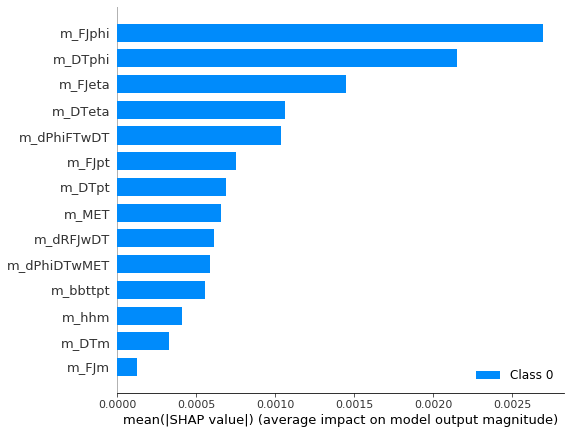

In [87]:

shap.summary_plot(shap_values, X_test,plot_type="bar")

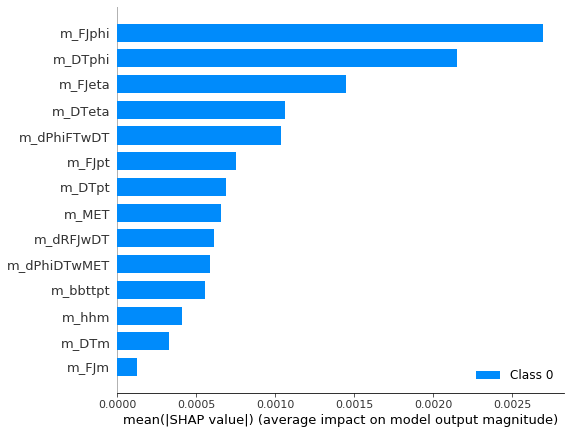

In [40]:
shap.summary_plot(shap_values, X_test, plot_type=)

In [21]:
shap_sum = np.abs(shap_values[0]).mean(axis=0)
print(shap_sum)
indices = np.argsort(shap_sum)[::-1]
print(indices)
print(df.columns[indices])

[0.00075034 0.00144882 0.00269218 0.00012325 0.00068944 0.00105997
 0.00215051 0.00032431 0.00103481 0.00061447 0.0005869  0.00065644
 0.00041009 0.00055271]
[ 2  6  1  5  8  0  4 11  9 10 13 12  7  3]
Index(['m_FJphi', 'm_DTphi', 'm_FJeta', 'm_DTeta', 'm_dPhiFTwDT', 'm_FJpt',
       'm_DTpt', 'm_MET', 'm_dRFJwDT', 'm_dPhiDTwMET', 'm_bbttpt', 'm_hhm',
       'm_DTm', 'm_FJm'],
      dtype='object')


In [22]:
print(Y_train.mean(), explainer.expected_value)

0.9780618084700496 [0.95537436]


In [23]:
X_test.mean()

m_FJpt          0.401638
m_FJeta         0.504624
m_FJphi         0.501174
m_FJm           0.157926
m_DTpt          0.282798
m_DTeta         0.503838
m_DTphi         0.490597
m_DTm           0.249006
m_dPhiFTwDT     0.902012
m_dRFJwDT       0.484807
m_dPhiDTwMET    0.497375
m_MET           0.242900
m_hhm           0.374301
m_bbttpt        0.239286
dtype: float64

In [24]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j,explainer,shap_values,S):
    p = shap.force_plot(explainer.expected_value, shap_values[j], S.iloc[[j]])
    return(p)

In [26]:
# Explain the prediction of one instance
shap_plot(0,explainer,shap_values[0], X_test)

In [27]:
#shap.force_plot(explainer.expected_value,shap_values[:50,:],X_test.iloc[:50,:])

In [29]:
expected_value = explainer.expected_value


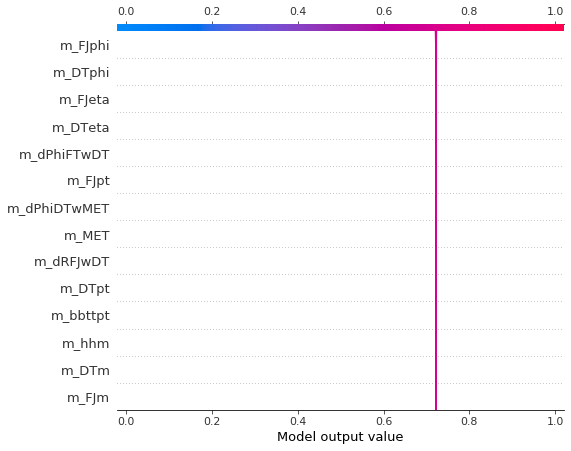

In [31]:
shap.decision_plot(expected_value, shap_values[0][0:30,:], df.iloc[0:30], link='logit')

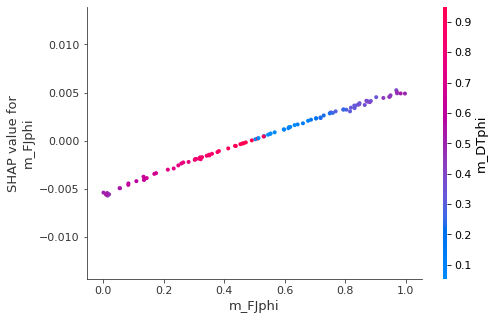

In [36]:
shap.dependence_plot("m_FJphi", shap_values[0], X_test[0:100])

[[  80   35]
 [2360 2767]]


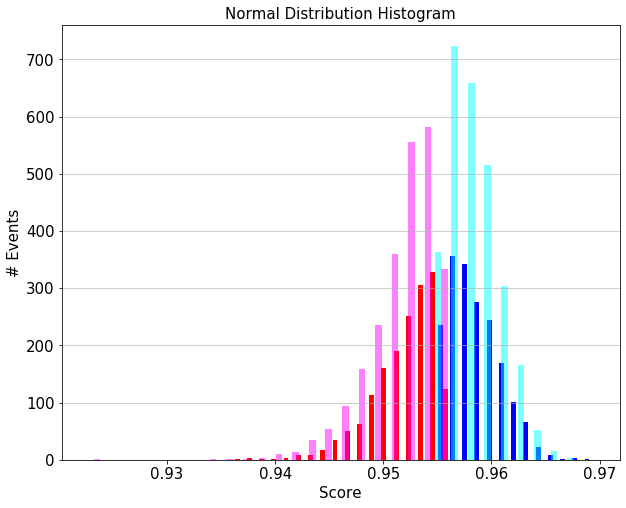

In [77]:
train_pred = model_v1.predict(X_train)
train_pred_bin = train_pred > train_pred.mean()
cm_train = confusion_matrix(Y_train, train_pred_bin)
print(cm_train)

pred = model_v1.predict(X_test)
test_pred = pred > pred.mean()
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(Y_test, test_pred)

from matplotlib import pyplot as plt
score_s = [i for i in pred if i > pred.mean()]
score_b = [i for i in pred if i <= pred.mean()]

score_s_train = [i for i in train_pred if i > train_pred.mean()]
score_b_train = [i for i in train_pred if i <= train_pred.mean()]

plt.figure(figsize=[10,8])
#n, bins, patches = plt.hist(x=pred, bins=8, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.hist([score_s, score_b], color=['blue', 'red'], bins=30)
plt.hist([score_s_train, score_b_train], color=['cyan', 'magenta'], bins=30, alpha=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Score',fontsize=15)
plt.ylabel('# Events',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Normal Distribution Histogram',fontsize=15)
plt.show()

In [67]:
a.sum()

1828

In [68]:
a.shape

(3495, 1)